In [4]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

# Méthode "Iterative Closest Point"

## 1.Problème:

Dans le nuage des points obtenu par lidar, on peut obtenir des clusters par DBSCANS. Notre objective est de trouver les clusters qui rassemblent à notre balise.

### Première approche

En premier temps, nous allons appliquer le méthode d'ICP. Le principe de cette méthode est de calculer la transformation optimale (composée d'une rotation et d'une translation) minimisant un critère de distance entre 2 nuage de points. Nous avons construit un dataset de balises en différent distance (). Nous allons l'utiliser comme le standard pour comparer. 

### Modélisation le problème

Soit $M_k$ notre kième cluster. Selon la distance de ce cluster, on choisi le standard S pour comparer.
Notre problème s'écrit:

$ min_{T \in \mathcal{T}} || T(M_k)-S|| $

où $\mathcal{T}$ est l'ensemble des transformation composée d'une rotation et d'une translation


In [25]:
#Notre nuage de point: 
# Loading dataset
df = pd.read_csv('Data/data.csv')
pd.options.display.max_rows = 100
NB_SAMPLES = 20

# Error corecction
x = df['x']
df['x'] = df['angle']
df['angle'] = x

y = df['y']
df['y'] = df['dist']
df['dist'] = y

# Dbscan Clustering
clustering = DBSCAN(eps=50, min_samples=3*NB_SAMPLES).fit_predict(df[['x','y']])
# angle / distance

df['clus']=clustering

clus1=df[df['clus']==0]

clus1

,dist,angle,x,y,sample,clus
0,1591,-117.068319,-1416.729114,-723.988686,0,0
1,1571,-116.716233,-1403.286399,-706.277765,0,0
2,1571,-116.364148,-1407.599986,-697.641226,0,0
3,1571,-116.012063,-1411.860419,-688.978342,0,0
4,1576,-115.659978,-1420.574438,-682.454590,0,0
5,1592,-115.307893,-1439.205683,-680.551983,0,0
6,1610,-114.955808,-1459.679909,-679.289749,0,0
583,1586,-117.068319,-1412.276791,-721.713423,1,0
584,1572,-116.716233,-1404.179643,-706.727337,1,0
585,1572,-116.364148,-1408.495976,-698.085300,1,0


In [62]:
theta=0
W=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])


## 2. Algorithm ICP

Notre transformation s'écrit:

$\binom{x'}{y'}=\binom{cos \theta \ \ \ -sin \theta}{sin \theta \ \ \ cos \theta} \binom{x}{y} + \binom{a}{b} $

(x',y') point dans le nuage standard, (x,y) point dans le cluster

Soient $u_i=(x_i',y_i') $ et $v_i=(x_i,y_i) $ ième point dans le standard et le nuage pour $i=1,...,N$ (N:nombre de points dans le nuage) ,

Notre problème à minimiser

$\sum_{i=1}^N ||T(v_i)-u_i||²$


In [63]:
d=W.dot(df[['x','y']].T)

In [61]:
theta=
W=np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)])


In [64]:
pd.DataFrame(data=d.T,columns=['x','y'])

,x,y
0,-1416.729114,-723.988686
1,-1403.286399,-706.277765
2,-1407.599986,-697.641226
3,-1411.860419,-688.978342
4,-1420.574438,-682.454590
...,...,...
5847,1671.000711,-906.398160
5848,1661.019014,-914.238391
5849,1655.369651,-924.428103
5850,1632.256326,-924.724437


In [74]:
def transformation(theta,a,b,nuage):
    #nuage: 
    W=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    d=W.dot(nuage[['x','y']].T)
    return pd.DataFrame(data=d.T,columns=['x','y'])

In [ ]:
def det_trans(nuage, stand,init,eps):
    # Input: 2 nuages de points: cluster et standard, init=(theta0,a0,b0)
    # Output: la transformation optimale (theta,a,b)
    # Méthode: Gradient descent avec le pas par la recherche linéaire
    def feval(nuage,stand,val):
        return np.sum(np.linalg.norm(transformation(nuage)-stand,2))
    def grad(nuage,stand,val):
        return
    def linesearch(val,step,descent,cost_old) :
        (theta,a,b)=val
        (desct,desca,descb)=descent
        step=2*step
        tmp=(theta-step*desct,a-step*desca,b-step*descb)
        cost=feval(nuage,stand,val)
        while cost >cost_old and step > 1.e-8:
            step=0.5*step
            tmp=(theta-step*desct,a-step*desca,b-step*descb)
            cost=feval(nuage,stand,val)
        return tmp,step,cost
    val=init
    step_list=[]
    niter=0
    step=stepini
    cost=feval(nuage,stand,val)
    CF=[cost]
     while niter < nitermax and step > 1.e-8 : 
        niter+=1
        grad=grad(nuage,stand,val)
        val,step,cost=linesearch(val,step,grad,cost)
        step_list.append(step)
        CF.append(cost)

    
    

## 3. Tester le méthode avec les fausses données 

In [75]:
d = {'x': np.linspace(-1,1,10), 'y': (np.linspace(-1,1,10))**2+np.random.normal(0, 0.05,10)}
stand = pd.DataFrame(data=d)

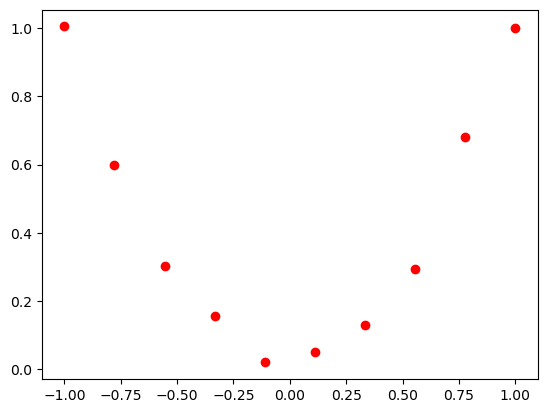

In [76]:
plt.plot(stand['x'],stand['y'],'ro')

In [77]:
nuage=transformation(np.pi,1,2,stand)

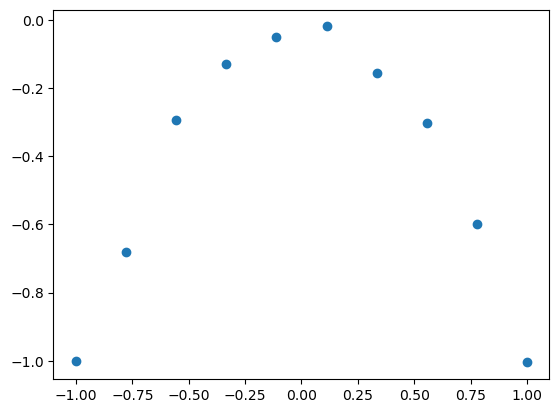

In [78]:
plt.plot(nuage['x'],nuage['y'],'o')

In [ ]:
np.sum(np.linalg.norm(nuage[['x',-stand,2))